***Financial Time-Series Anomaly Detection***

***Loading Modules***

In [7]:
#TODO:ANOMALY DETECTION IN TIME-SERIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from ta.volatility import BollingerBands
from ta.trend import SMAIndicator,EMAIndicator
from prophet import Prophet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [8]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize']=(14,8)


***Loading and pre-processing***

In [9]:
ticker='S&P 500'
data_file='data.csv'
print(f"Loading data from {data_file}")
df=pd.read_csv(data_file)

Loading data from data.csv


***convert data column to datetime***

In [10]:
df['formatted_date']=pd.to_datetime(df['formatted_date'])
df.set_index('formatted_date',inplace=True)

In [11]:
df=df.rename(columns={
    'close': 'Close',
    'open': 'Open',
    'high': 'High',
    'low': 'Low',
    'volume': 'Volume',
    'rsi': 'rsi',
    'd_return': 'daily_return'
})

In [12]:
df.dropna(inplace=True)

In [13]:
df.shape

(1857, 20)

In [14]:
df.dtypes

,0
High,float64
Low,float64
Open,float64
Close,float64
Volume,int64
adjclose,float64
rsi,float64
daily_return,float64
volume_change,float64
r_lag1,float64


In [15]:
df['day']=df.index.day
df['month']=df.index.month
df['year']=df.index.year
df['day_of_week']=df.index.dayofweek
df['is_quarter_end'] = df.index.is_quarter_end.astype(int)

***Calculate Financial Indicators***

In [17]:
window=20
bb=BollingerBands(close=df['Close'],window=window)
df['bb_bbm']=bb.bollinger_mavg()
df['bb_bbh']=bb.bollinger_hband()
df['bb_bbl']=bb.bollinger_lband()


In [18]:
sma=SMAIndicator(close=df['Close'],window=window)
df['sma']=sma.sma_indicator()
ema=EMAIndicator(close=df['Close'],window=window)
df['ema']=ema.ema_indicator()

In [19]:
df['volatility']=df['daily_return'].rolling(window=window).std()

In [21]:
df.dropna(inplace=True)

***Unsupervized anomaly detection***

In [22]:
#ISOLATED FOREST
print("Running Isolation Forest anomaly detection...")
features = ['Close', 'Volume', 'daily_return', 'volatility', 'rsi', 'sma', 'ema', 'bb_bbh', 'bb_bbl']
X_if=df[features].copy()
scaler=StandardScaler()
X_if_scaled=scaler.fit_transform(X_if)
model_if=IsolationForest(contamination=0.05,random_state=42)
df['isolation_forest']=model_if.fit_predict(X_if_scaled)

Running Isolation Forest anomaly detection...


In [23]:
#DBSCAN
print("Running DBSCAN anomaly detection...")
features_dbscan = ['Close', 'rsi']
X_dbscan = df[features_dbscan].copy()
scaler_dbscan = StandardScaler()
X_dbscan_scaled = scaler_dbscan.fit_transform(X_dbscan)

model_dbscan = DBSCAN(eps=0.5, min_samples=5)
df['dbscan'] = model_dbscan.fit_predict(X_dbscan_scaled)

Running DBSCAN anomaly detection...


In [31]:
#LSTM
print("Running LSTM anomaly detection...")
close_prices=df['Close'].values
scaler_lstm=StandardScaler()
close_scaled=scaler_lstm.fit_transform(close_prices.reshape(-1,1))


Running LSTM anomaly detection...


In [32]:
#prepare lstm data
n_steps=30
X_lstm,y_lstm=[],[]
for i in range(n_steps,len(close_scaled)):
  X_lstm.append(close_scaled[i-n_steps:i])
  y_lstm.append(close_scaled[i])
X_lstm=np.array(X_lstm)
y_lstm=np.array(y_lstm)



In [33]:
#split data
split=int(0.8*len(X_lstm))
X_train,X_test=X_lstm[:split],X_lstm[split:]
y_train,y_test=y_lstm[:split],y_lstm[split:]

In [34]:
#build and train lstm
model_lstm=Sequential([
    LSTM(50,return_sequences=True,input_shape=(n_steps,1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])
model_lstm.compile(optimizer='adam',loss='mse')
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_lstm.fit(X_train, y_train,
               epochs=50,
               batch_size=32,
               validation_data=(X_test, y_test),
               callbacks=[early_stop],
               verbose=0)

In [37]:
#lstm predictions
predictions=[]
current_batch=close_scaled[:n_steps].reshape(1,n_steps,1)
for i in range(len(close_scaled)):
  pred=model_lstm.predict(current_batch,verbose=0)
  predictions.append(pred[0,0])
  if i<len(close_scaled)-1:
    current_batch=np.roll(current_batch,-1,axis=1)
    current_batch[0,-1,0]=close_scaled[i+1]

predictions=scaler_lstm.inverse_transform(np.array(predictions).reshape(-1,1)).flatten()
df['lstm_pred'] = np.nan
df.iloc[:len(predictions), df.columns.get_loc('lstm_pred')] = predictions



In [38]:
# Detect LSTM anomalies
df['lstm_residual'] = df['Close'] - df['lstm_pred']
lstm_threshold = df['lstm_residual'].mean() + 2 * df['lstm_residual'].std()
df['lstm_anomaly'] = (abs(df['lstm_residual']) > lstm_threshold).astype(int)

In [39]:
print("Running Prophet anomaly detection...")
prophet_df = df.reset_index()[['formatted_date', 'Close']].rename(columns={'formatted_date': 'ds', 'Close': 'y'})
model_prophet = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
model_prophet.fit(prophet_df)

future = model_prophet.make_future_dataframe(periods=0)
forecast = model_prophet.predict(future)

forecast = forecast.set_index('ds')
df = df.join(forecast[['yhat', 'yhat_lower', 'yhat_upper']], how='left')

Running Prophet anomaly detection...


DEBUG:cmdstanpy:input tempfile: /tmp/tmpb_3r3vvc/uw0lqydb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb_3r3vvc/hrszyabp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44274', 'data', 'file=/tmp/tmpb_3r3vvc/uw0lqydb.json', 'init=/tmp/tmpb_3r3vvc/hrszyabp.json', 'output', 'file=/tmp/tmpb_3r3vvc/prophet_modelx5um002r/prophet_model-20250413184147.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [40]:
# Detect Prophet anomalies
df['prophet_residual'] = df['Close'] - df['yhat']
prophet_threshold = df['prophet_residual'].mean() + 2 * df['prophet_residual'].std()
df['prophet_anomaly'] = (abs(df['prophet_residual']) > prophet_threshold).astype(int)

***Visualize results***

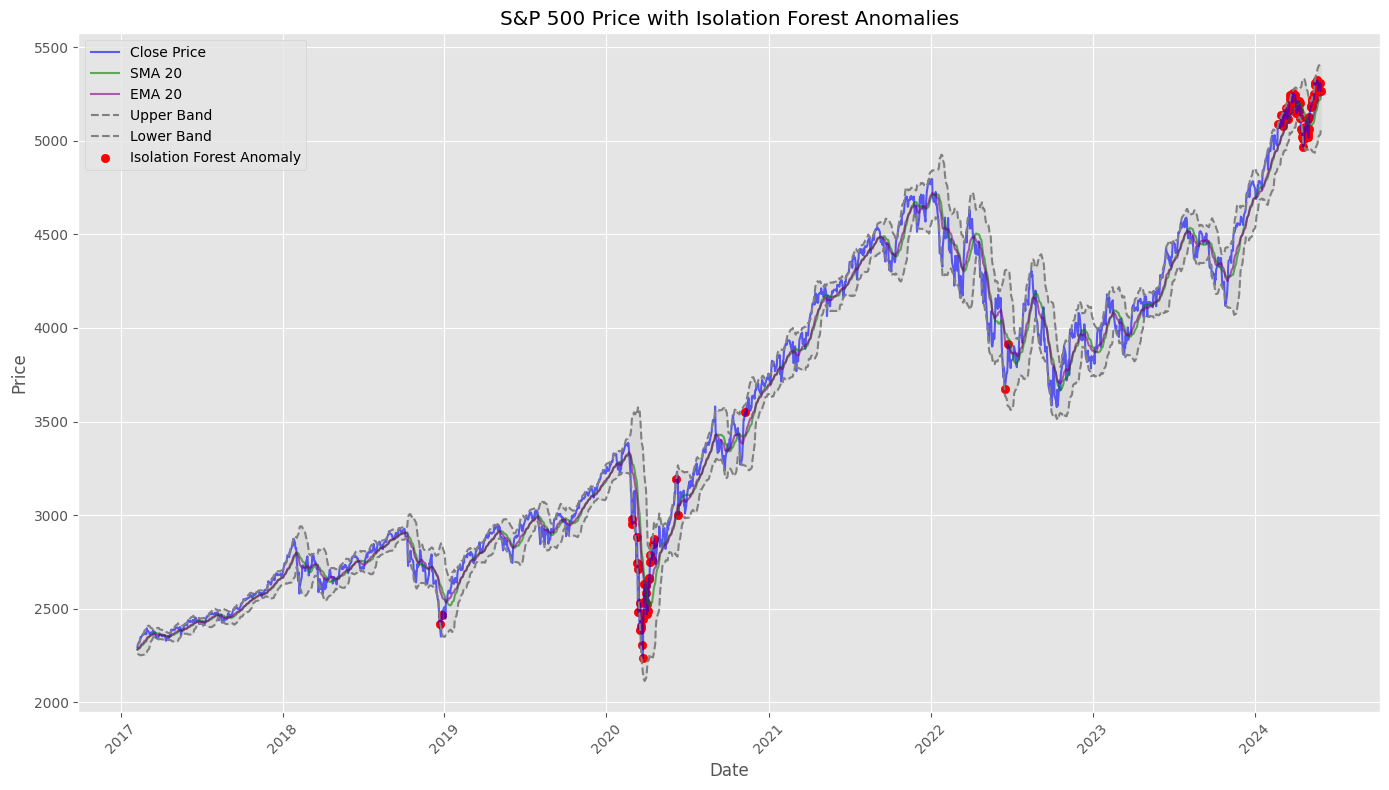

In [41]:
fig1, ax1 = plt.subplots()
ax1.plot(df.index, df['Close'], color='blue', label='Close Price', alpha=0.6)
ax1.plot(df.index, df['sma'], color='green', label=f'SMA {window}', alpha=0.6)
ax1.plot(df.index, df['ema'], color='purple', label=f'EMA {window}', alpha=0.6)
ax1.plot(df.index, df['bb_bbh'], color='gray', linestyle='--', label='Upper Band')
ax1.plot(df.index, df['bb_bbl'], color='gray', linestyle='--', label='Lower Band')
ax1.fill_between(df.index, df['bb_bbl'], df['bb_bbh'], color='gray', alpha=0.1)
anomalies_if = df[df['isolation_forest'] == -1]
ax1.scatter(anomalies_if.index, anomalies_if['Close'], color='red', label='Isolation Forest Anomaly')
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)
plt.title(f'{ticker} Price with Isolation Forest Anomalies')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

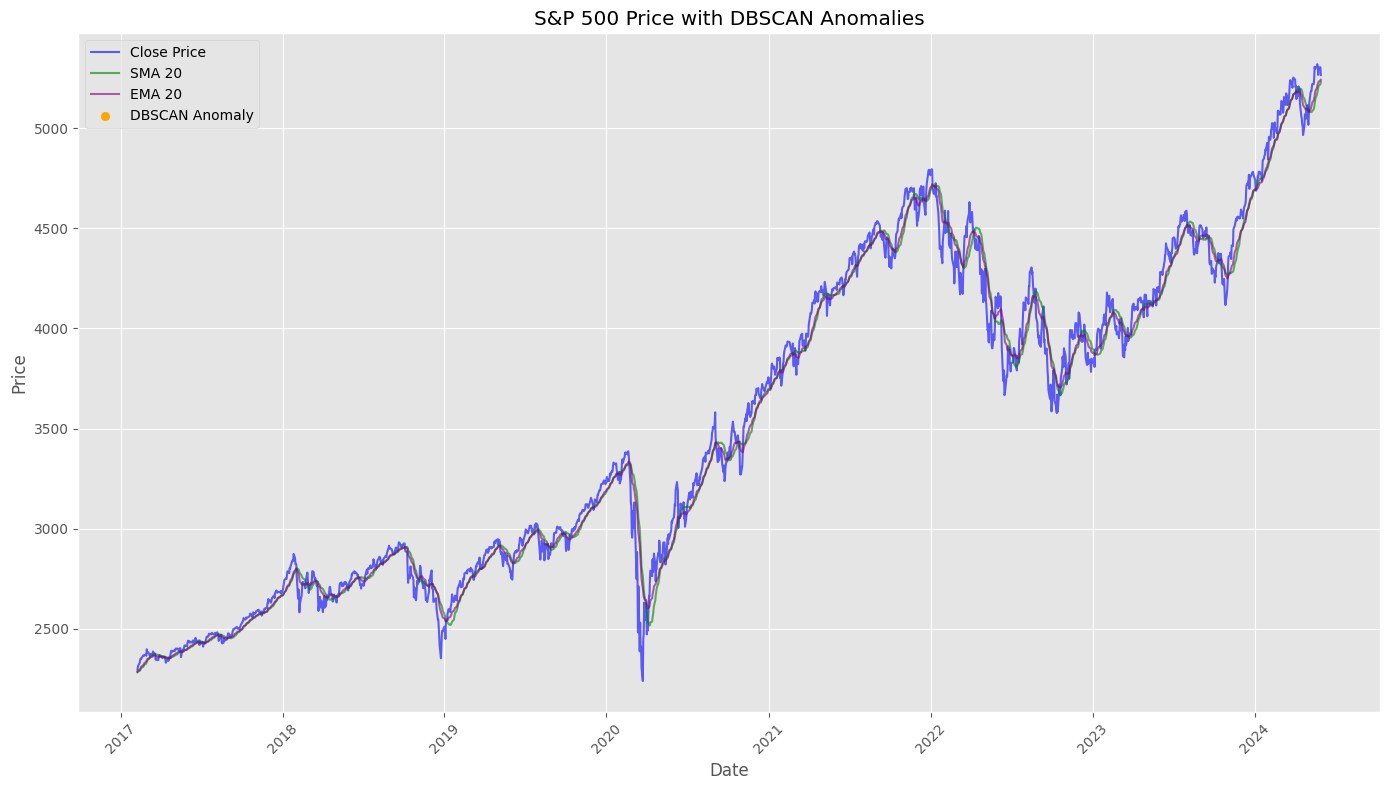

In [42]:
fig2, ax2 = plt.subplots()
ax2.plot(df.index, df['Close'], color='blue', label='Close Price', alpha=0.6)
ax2.plot(df.index, df['sma'], color='green', label=f'SMA {window}', alpha=0.6)
ax2.plot(df.index, df['ema'], color='purple', label=f'EMA {window}', alpha=0.6)
anomalies_dbscan = df[df['dbscan'] == -1]
ax2.scatter(anomalies_dbscan.index, anomalies_dbscan['Close'], color='orange', label='DBSCAN Anomaly')
ax2.xaxis.set_major_locator(mdates.YearLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)
plt.title(f'{ticker} Price with DBSCAN Anomalies')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

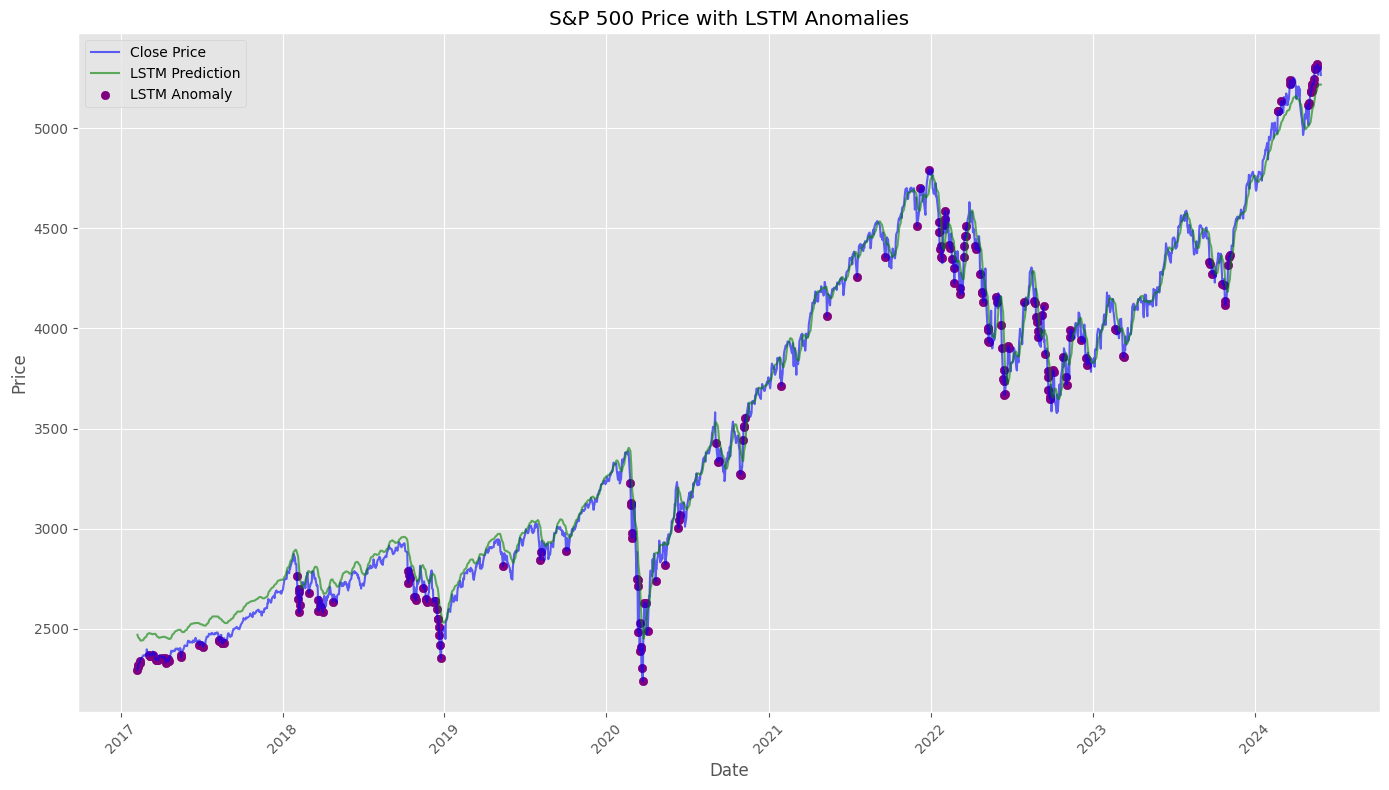

In [43]:
fig3, ax3 = plt.subplots()
ax3.plot(df.index, df['Close'], color='blue', label='Close Price', alpha=0.6)
ax3.plot(df.index, df['lstm_pred'], color='green', label='LSTM Prediction', alpha=0.6)
anomalies_lstm = df[df['lstm_anomaly'] == 1]
ax3.scatter(anomalies_lstm.index, anomalies_lstm['Close'], color='purple', label='LSTM Anomaly')
ax3.xaxis.set_major_locator(mdates.YearLocator())
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)
plt.title(f'{ticker} Price with LSTM Anomalies')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

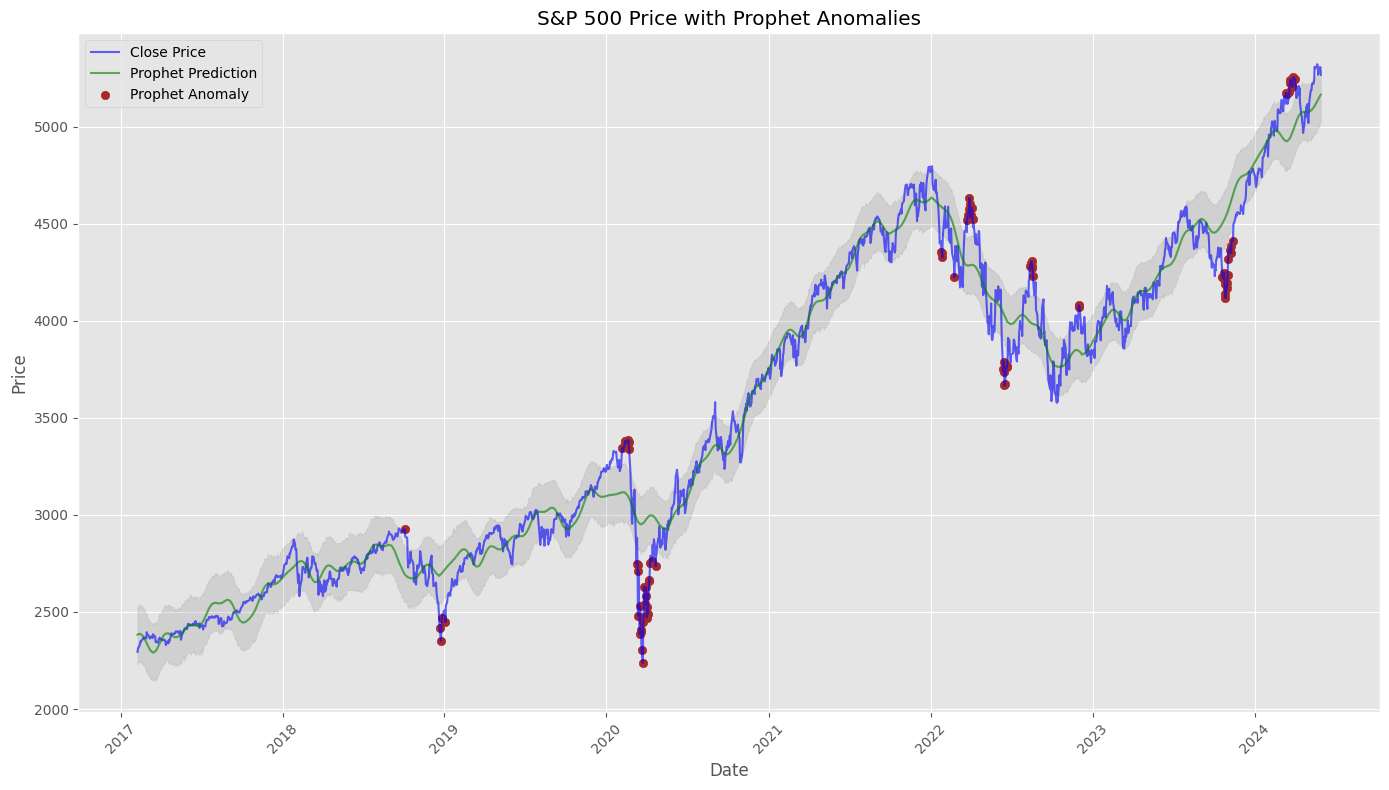

In [44]:
fig4, ax4 = plt.subplots()
ax4.plot(df.index, df['Close'], color='blue', label='Close Price', alpha=0.6)
ax4.plot(df.index, df['yhat'], color='green', label='Prophet Prediction', alpha=0.6)
ax4.fill_between(df.index, df['yhat_lower'], df['yhat_upper'], color='gray', alpha=0.2)
anomalies_prophet = df[df['prophet_anomaly'] == 1]
ax4.scatter(anomalies_prophet.index, anomalies_prophet['Close'], color='brown', label='Prophet Anomaly')
ax4.xaxis.set_major_locator(mdates.YearLocator())
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)
plt.title(f'{ticker} Price with Prophet Anomalies')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

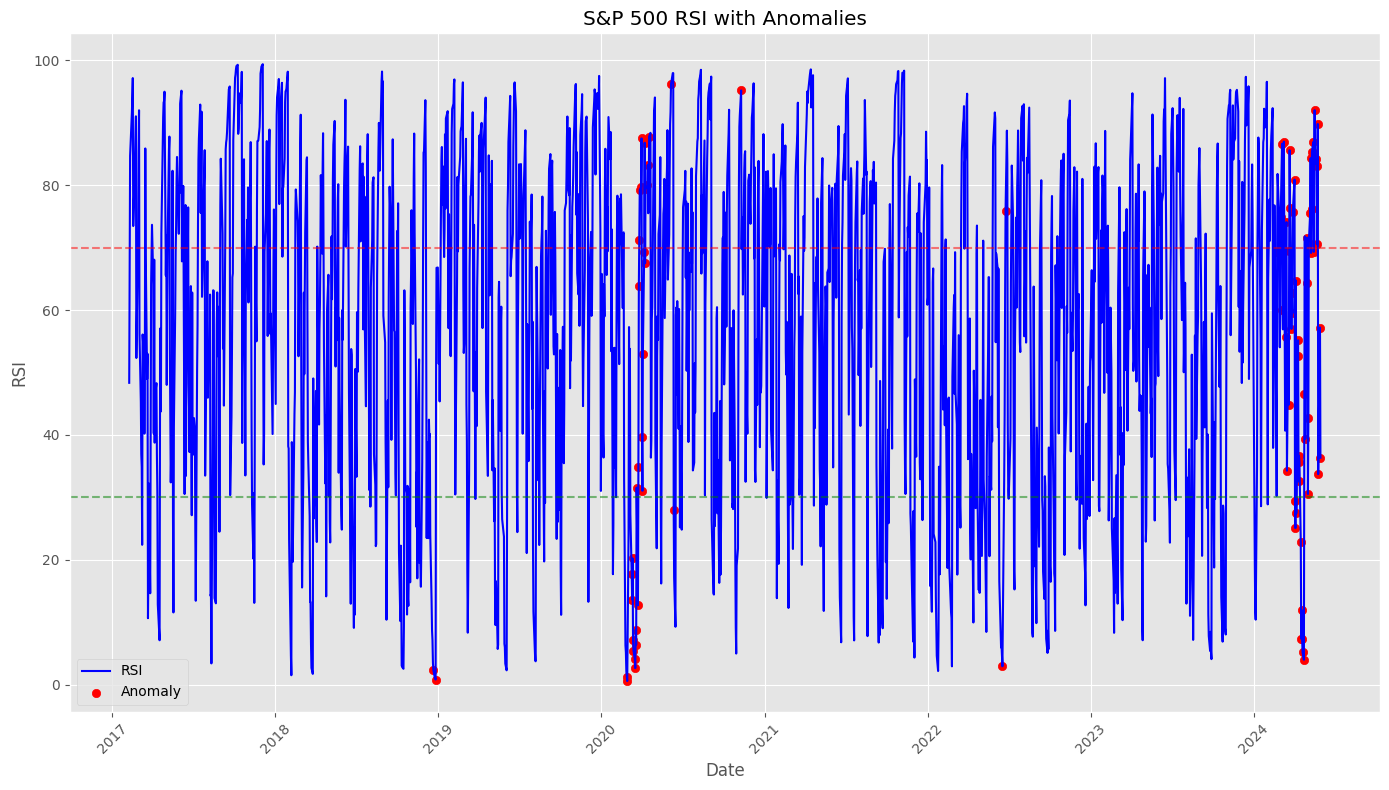

In [45]:
fig5, ax5 = plt.subplots()
ax5.plot(df.index, df['rsi'], label='RSI', color='blue')
ax5.axhline(70, linestyle='--', color='red', alpha=0.5)
ax5.axhline(30, linestyle='--', color='green', alpha=0.5)
anomalies_rsi = df[df['isolation_forest'] == -1]
ax5.scatter(anomalies_rsi.index, anomalies_rsi['rsi'], color='red', label='Anomaly')
ax5.xaxis.set_major_locator(mdates.YearLocator())
ax5.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)
plt.title(f'{ticker} RSI with Anomalies')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend()
plt.tight_layout()
plt.show()

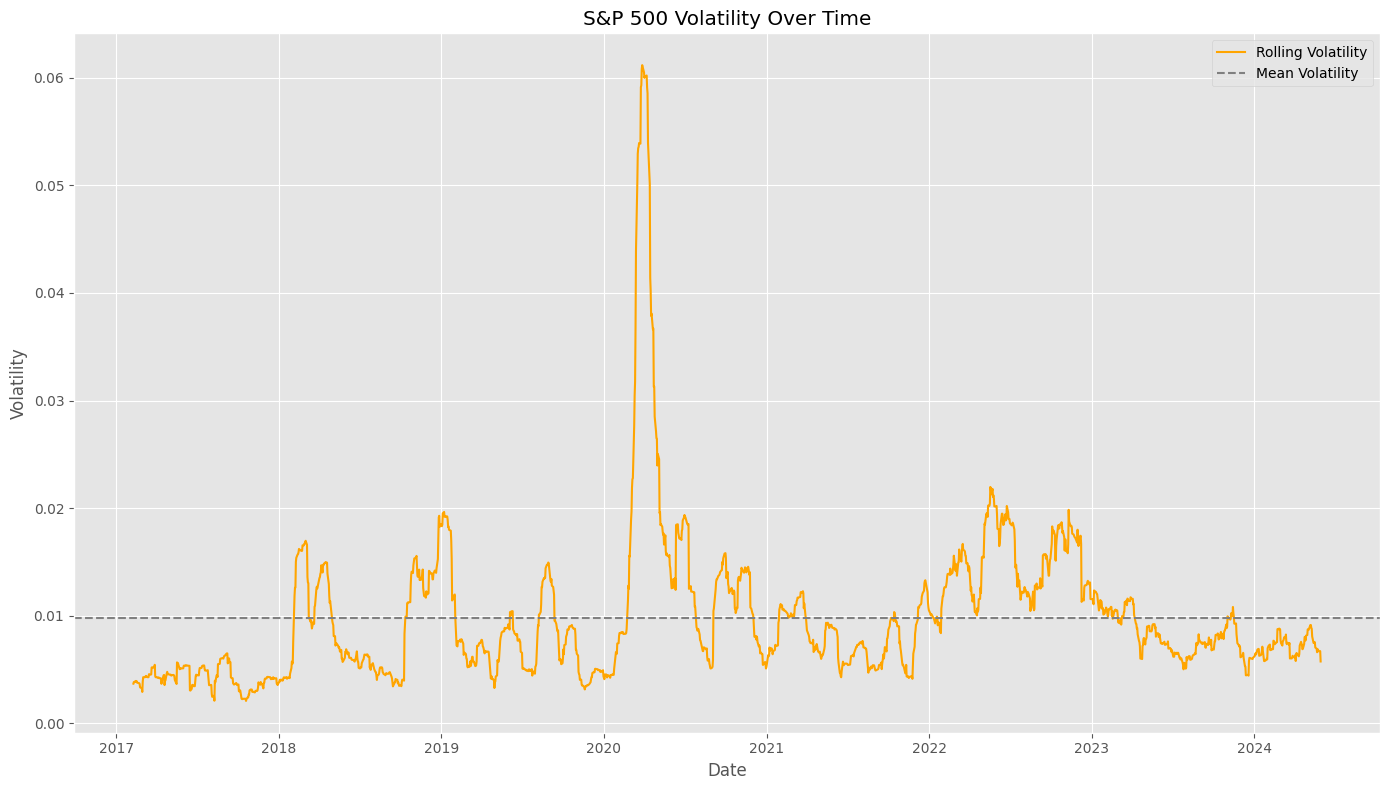

In [48]:
fig, ax = plt.subplots()
ax.plot(df.index, df['volatility'], color='orange', label='Rolling Volatility')
ax.axhline(df['volatility'].mean(), linestyle='--', color='gray', label='Mean Volatility')
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.title(f'{ticker} Volatility Over Time')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.tight_layout()
plt.show()


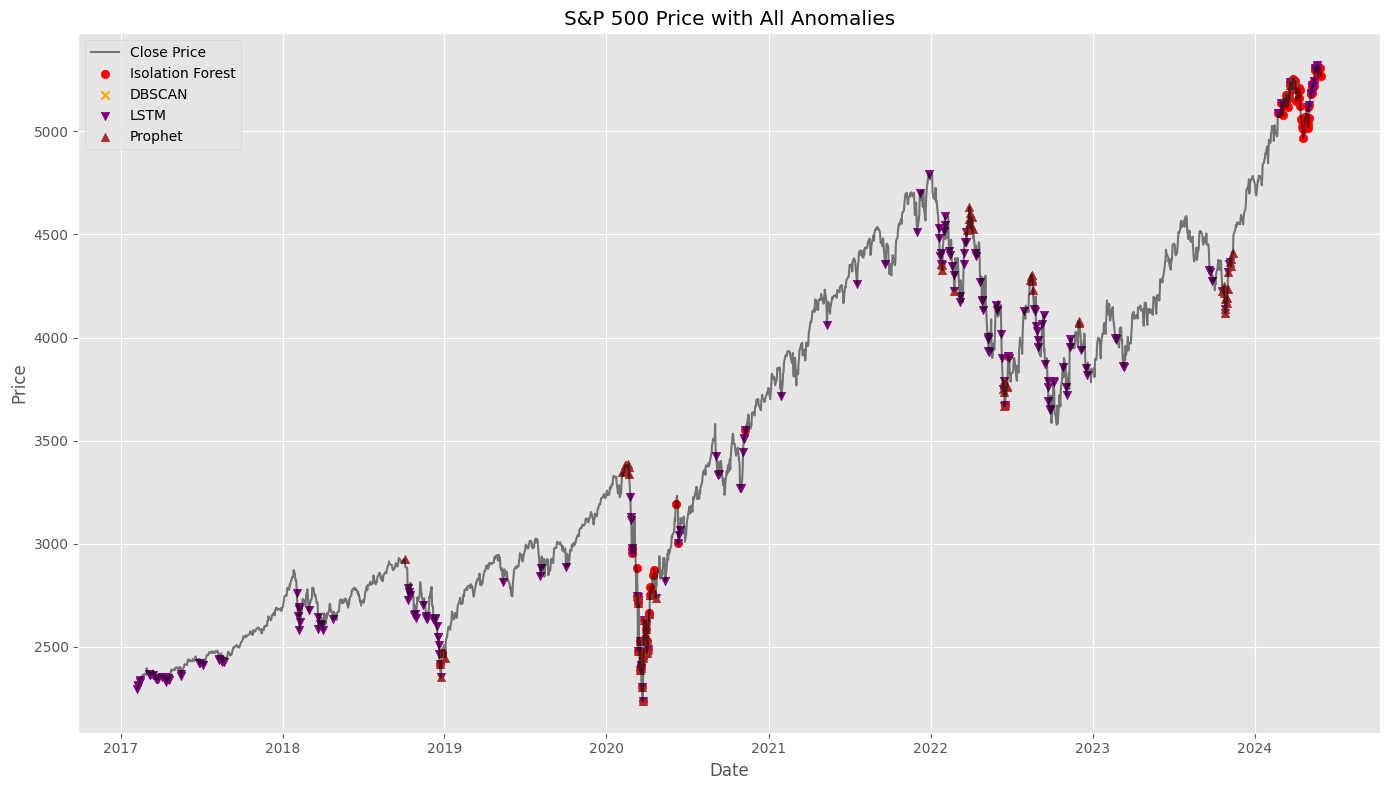

In [49]:
fig, ax = plt.subplots()
ax.plot(df.index, df['Close'], label='Close Price', alpha=0.5, color='black')
ax.scatter(df[df['isolation_forest'] == -1].index, df[df['isolation_forest'] == -1]['Close'],
           label='Isolation Forest', color='red', marker='o')
ax.scatter(df[df['dbscan'] == -1].index, df[df['dbscan'] == -1]['Close'],
           label='DBSCAN', color='orange', marker='x')
ax.scatter(df[df['lstm_anomaly'] == 1].index, df[df['lstm_anomaly'] == 1]['Close'],
           label='LSTM', color='purple', marker='v')
ax.scatter(df[df['prophet_anomaly'] == 1].index, df[df['prophet_anomaly'] == 1]['Close'],
           label='Prophet', color='brown', marker='^')
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.title(f'{ticker} Price with All Anomalies')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()


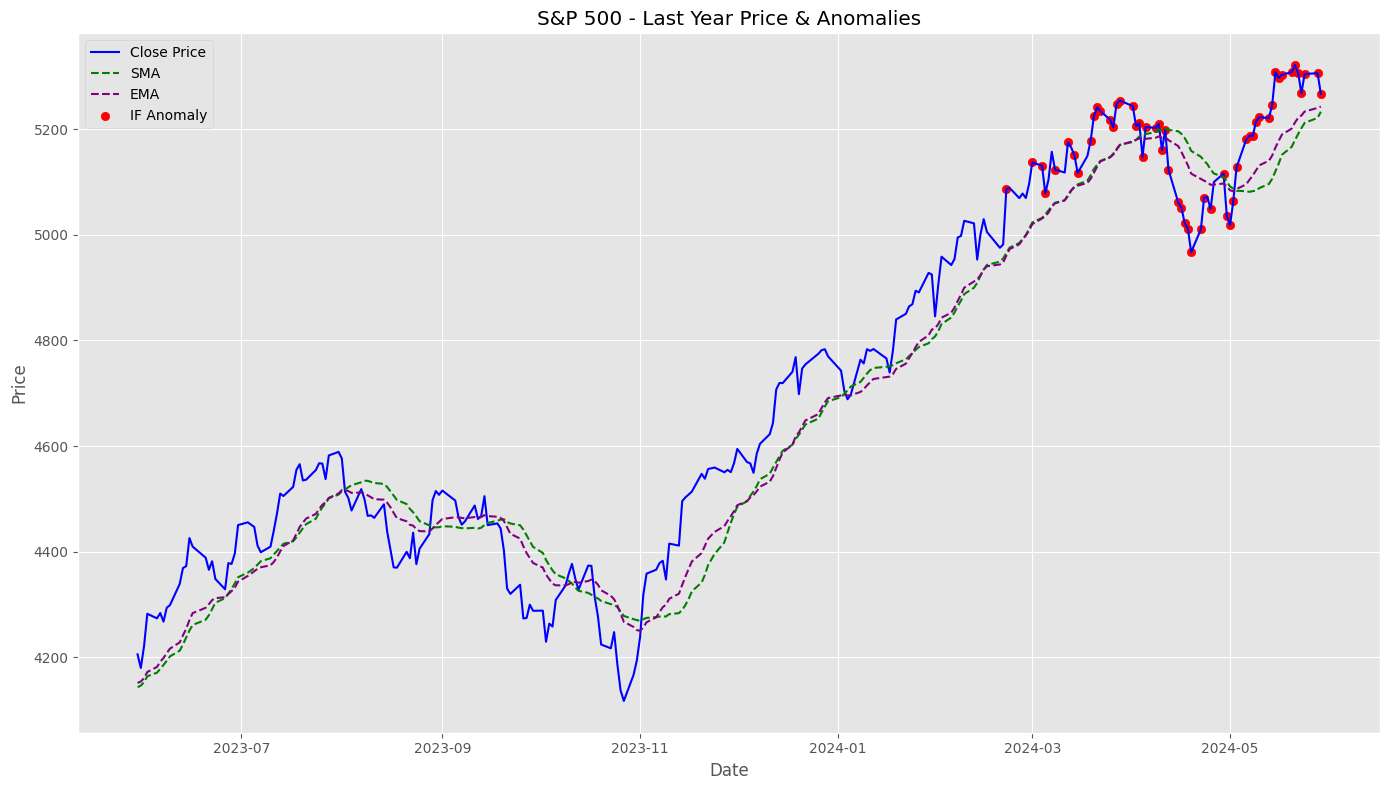

In [50]:
recent_df = df[df.index >= df.index.max() - pd.DateOffset(years=1)]
fig, ax = plt.subplots()
ax.plot(recent_df.index, recent_df['Close'], color='blue', label='Close Price')
ax.plot(recent_df.index, recent_df['sma'], color='green', linestyle='--', label='SMA')
ax.plot(recent_df.index, recent_df['ema'], color='purple', linestyle='--', label='EMA')
ax.scatter(recent_df[recent_df['isolation_forest'] == -1].index,
           recent_df[recent_df['isolation_forest'] == -1]['Close'],
           color='red', label='IF Anomaly')
plt.title(f'{ticker} - Last Year Price & Anomalies')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()


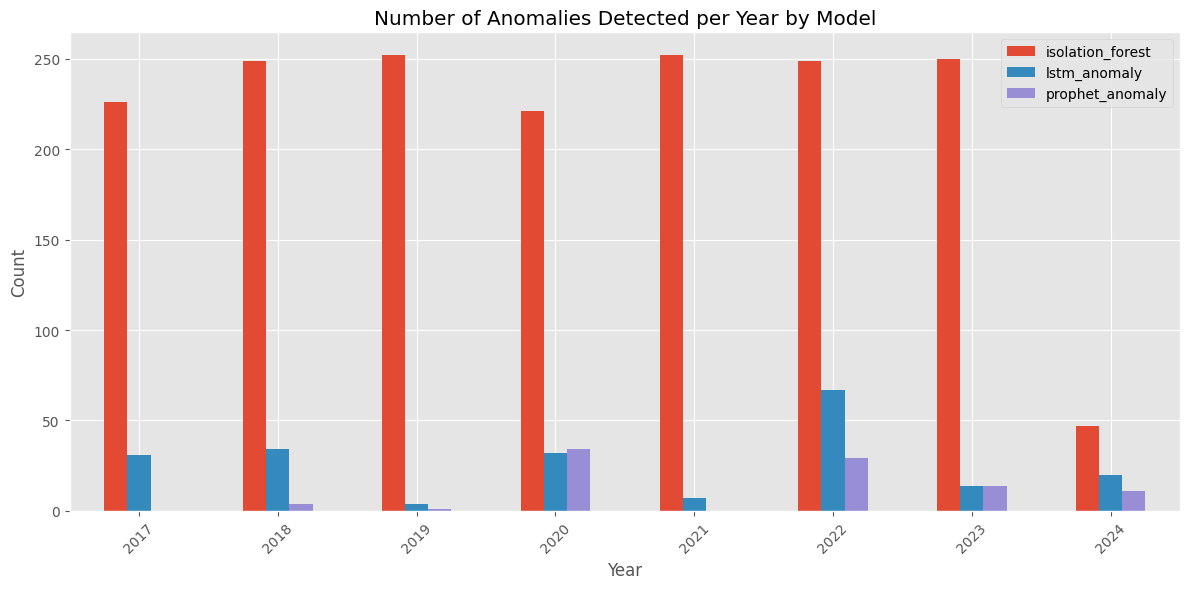

In [51]:
df['year'] = df.index.year
anomaly_counts = df.groupby('year')[['isolation_forest', 'lstm_anomaly', 'prophet_anomaly']].apply(
    lambda x: (x == -1 if x.name == 'isolation_forest' else x == 1).sum())

anomaly_counts.plot(kind='bar', figsize=(12, 6))
plt.title('Number of Anomalies Detected per Year by Model')
plt.ylabel('Count')
plt.xlabel('Year')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


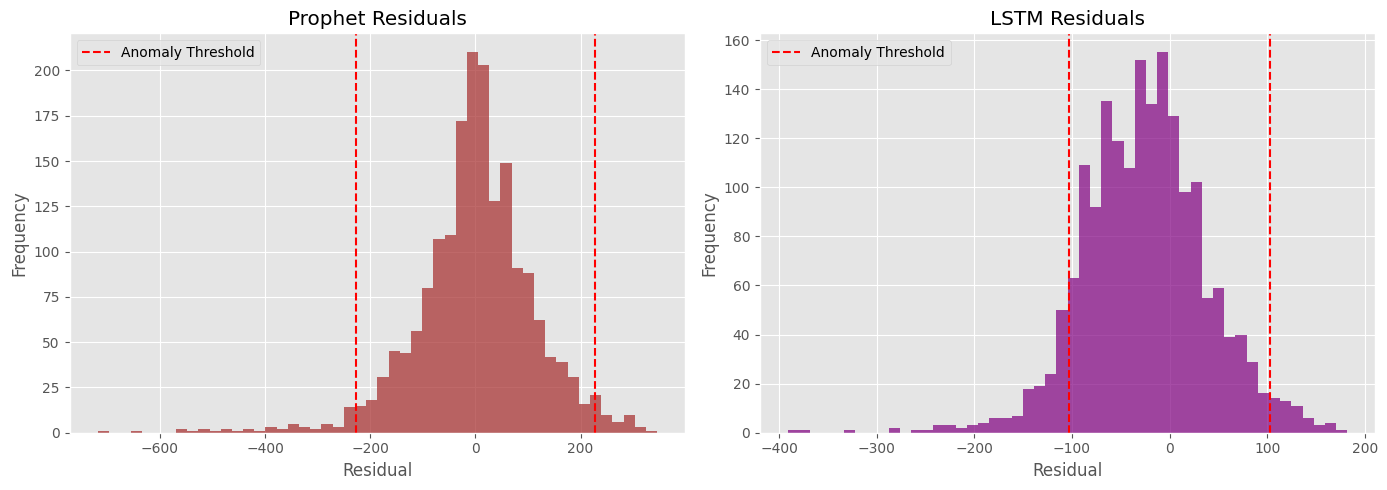

In [52]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
axs[0].hist(df['prophet_residual'].dropna(), bins=50, color='brown', alpha=0.7)
axs[0].axvline(prophet_threshold, color='red', linestyle='--', label='Anomaly Threshold')
axs[0].axvline(-prophet_threshold, color='red', linestyle='--')
axs[0].set_title('Prophet Residuals')

axs[1].hist(df['lstm_residual'].dropna(), bins=50, color='purple', alpha=0.7)
axs[1].axvline(lstm_threshold, color='red', linestyle='--', label='Anomaly Threshold')
axs[1].axvline(-lstm_threshold, color='red', linestyle='--')
axs[1].set_title('LSTM Residuals')

for ax in axs:
    ax.legend()
    ax.set_xlabel('Residual')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()
